In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt

import skimage

from PIL import Image
from pkg_resources import packaging

import torch
import torchvision
import torchvision.transforms as transforms
print("Torch version:", torch.__version__)

import clip

Torch version: 1.10.2+cu102


In [3]:
# load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root="../data/CIFAR10/", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="../data/CIFAR10/", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

torch.Size([3, 36, 138])


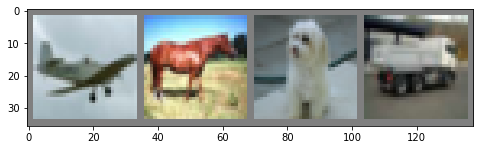

In [5]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# get some random sample images
dataitr = iter(trainloader)
imgs, labels = dataitr.next()

sample_imgs = torchvision.utils.make_grid(imgs)

print(sample_imgs.shape)

sample_imgs = 0.5 * sample_imgs + 0.5
sample_imgs = sample_imgs.numpy()

plt.figure(figsize=(8,6))
plt.imshow(np.transpose(sample_imgs, (1,2,0)))
plt.show()

In [51]:
print("Available CLIP models:", clip.available_models())

# model, preprocess = clip.load("ViT-B/32")
model, preprocess = clip.load("RN50")

Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fcbc4a8faf0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [53]:
print("Image Preprocessing Transform:\n", preprocess)

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

num_parameters = 0
for p in model.parameters():
    num_parameters += np.prod(p.shape)

print("Model parameters:", int(num_parameters))

Image Preprocessing Transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fcbc4a8faf0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Input resolution: 224
Context length: 77
Vocab size: 49408
Model parameters: 102007137


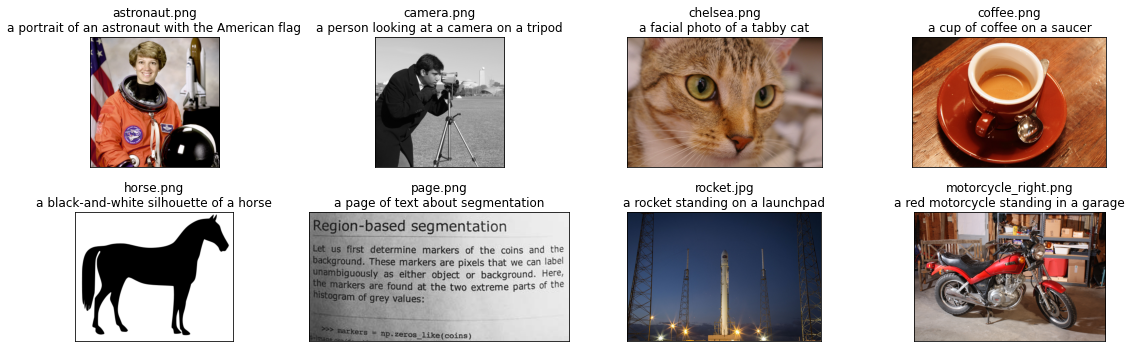

In [49]:
# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

original_imgs = []
processed_imgs = []
texts = []

plt.figure(figsize=(16, 5))

for filename in os.listdir(skimage.data_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        name = os.path.splitext(filename)[0]

        if name not in descriptions:
            continue
        
        img = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
        
        plt.subplot(2, 4, len(processed_imgs) + 1)
        plt.imshow(img)
        plt.title(f"{filename}\n{descriptions[name]}")
        plt.xticks([])
        plt.yticks([])
        
        original_imgs.append(img)
        processed_imgs.append(preprocess(img))
        
        texts.append(descriptions[name])
    
plt.tight_layout()

In [56]:
processed_imgs[0].shape

torch.Size([3, 224, 224])

In [58]:
np.stack(processed_imgs).shape

(8, 3, 224, 224)

In [61]:
img_input = torch.tensor(np.stack(processed_imgs)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

with torch.no_grad():
    img_features = model.encode_image(img_input).float()
    text_features = model.encode_text(text_tokens).float()

In [64]:
print("Image Features:", img_features.shape)
print("Text features:", text_features.shape)

Image Features: torch.Size([8, 1024])
Text features: torch.Size([8, 1024])


tensor([0.1193, 0.1337, 0.0678,  ..., 0.0975, 0.1332, 0.3860], device='cuda:0')

In [81]:
img_features = img_features / torch.linalg.norm(img_features, dim=0)
print(img_features.shape)
text_features = text_features / torch.linalg.norm(text_features, dim=0)
print(text_features.shape)
print(img_features.max(), img_features.min())

similarity_mat = np.matmul(text_features.cpu().numpy(), img_features.cpu().numpy().T)
print(similarity_mat.shape)

torch.Size([8, 1024])
torch.Size([8, 1024])
tensor(0.9465, device='cuda:0') tensor(-0.9609, device='cuda:0')
(8, 8)


Text(0.5, 1.0, 'Cosine similarity between text and image features')

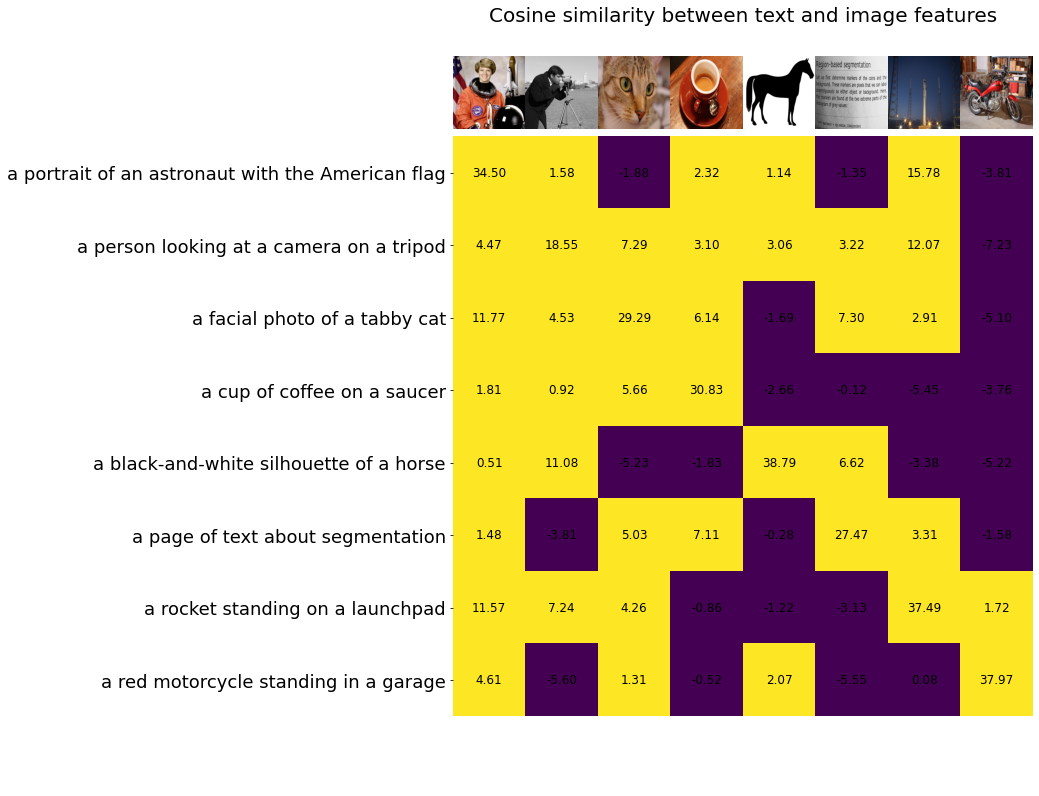

In [80]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity_mat, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_imgs):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity_mat.shape[1]):
    for y in range(similarity_mat.shape[0]):
        plt.text(x, y, f"{similarity_mat[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)